In [34]:
"""
Módulo para el preprocesamiento de corpus de noticias
Autor: Abraham MD
Fecha: 2025
"""

# === IMPORTACIONES ===
import pandas as pd
import unicodedata
import re
import html
import string
import pathlib
from typing import List, Tuple
import matplotlib.pyplot as plt

# === CONFIGURACIÓN GLOBAL ===
BASE_DIR = pathlib.Path.cwd().parent.resolve()

# Configuración de visualización
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [35]:
class TextPreprocessor:
    """
    Clase para el preprocesamiento de texto con métodos especializados
    """
    
    @staticmethod
    def to_lowercase(text: str) -> str:
        """Convierte texto a minúsculas"""
        return text.lower()
    
    @staticmethod
    def remove_accents(text: str) -> str:
        """Elimina tildes y acentos del texto"""
        normalized_text = unicodedata.normalize('NFD', text)
        return ''.join([char for char in normalized_text 
                       if unicodedata.category(char) != 'Mn'])
    
    @staticmethod
    def remove_digits(text: str) -> str:
        """Elimina todos los números del texto"""
        return re.sub(r'\d+', '', text)
    
    @staticmethod
    def remove_urls(text: str) -> str:
        """Elimina URLs y enlaces del texto"""
        url_patterns = [
            r"\b(?:https?://|www\.)\S+\b",
            r"\b(?:[A-Za-z0-9-]+\.)+[A-Za-z]{2,}(?:/\S*)?"
        ]
        combined_pattern = '|'.join(url_patterns)
        return re.sub(combined_pattern, "", text, flags=re.IGNORECASE)
    
    @staticmethod
    def remove_html_entities(text: str) -> str:
        """Elimina entidades HTML y etiquetas"""
        # Desescapar entidades HTML (&nbsp;, &amp;, etc.)
        clean_text = html.unescape(text)
        # Eliminar etiquetas HTML
        clean_text = re.sub(r'<[^>]+>', '', clean_text)
        return clean_text.strip()
    
    @staticmethod
    def remove_punctuation(text: str) -> str:
        """Elimina signos de puntuación"""
        return text.translate(str.maketrans('', '', string.punctuation))
    
    @staticmethod
    def remove_emoticons_emojis(text: str) -> str:
        """Elimina emoticones y emojis"""
        patterns = [
            r'[:;][\-]?[\)\(DPOp]',  # Emoticones textuales
            r'[\U0001F600-\U0001F64F]',  # Emojis de caras
            r'[\U0001F300-\U0001F5FF]',  # Símbolos y pictogramas
            r'[\U0001F680-\U0001F6FF]',  # Transporte y símbolos
            r'[\U0001F1E0-\U0001F1FF]'   # Banderas
        ]
        combined_pattern = '|'.join(patterns)
        return re.sub(combined_pattern, '', text)
    
    @staticmethod
    def normalize_whitespace(text: str) -> str:
        """Normaliza espacios en blanco, saltos de línea y tabulaciones (EJECUTAR AL FINAL)"""
        # Reemplazar saltos de línea y tabulaciones por espacios
        normalized_text = re.sub(r'[\r\n\t]+', ' ', text)
        # Colapsar múltiples espacios en uno solo
        normalized_text = re.sub(r'\s{2,}', ' ', normalized_text)
        return normalized_text.strip()
    
    @classmethod
    def clean_text(cls, text: str) -> str:
        """
        Pipeline completo de limpieza de texto
        
        Args:
            text (str): Texto a procesar
            
        Returns:
            str: Texto limpio y normalizado
        """
        pipeline = [
            cls.to_lowercase,
            cls.remove_accents,
            cls.remove_digits,
            cls.remove_urls,
            cls.remove_html_entities,
            cls.remove_punctuation,
            cls.remove_emoticons_emojis,
            cls.normalize_whitespace  # SIEMPRE AL FINAL
        ]
        
        processed_text = text
        for step in pipeline:
            processed_text = step(processed_text)
        
        return processed_text

# Crear instancia del preprocesador
preprocessor = TextPreprocessor()

In [37]:
# === CARGA DE DATOS FUENTE 1 ===


df_source_1 = pd.read_csv(
    '../data_scrapeada/noticias_combinadas.csv', 
    usecols=['descripcion', 'veracidad'],
    encoding='utf-8'
)

# Renombrar columnas para consistencia
df_source_1.rename(columns={'descripcion': 'text', 'veracidad': 'label'}, inplace=True)

# Convertir etiquetas a booleano
df_source_1['label'] = df_source_1['label'].astype(bool)

display(df_source_1.head())
    

,text,label
0,Distintas desinformaciones señalan falsamente ...,False
1,El metraje realmente corresponde a embarcacion...,False
2,Una cuenta desinformadora de derecha adelanta ...,False
3,Se trata de una suplantación que no ha sido pu...,False
4,Un video viral atribuye a Hugo “El Pollo” Carv...,False


In [41]:
# === CARGA DE DATOS FUENTE 2 ===

dataset_path = BASE_DIR / 'data/raw_corpus/full_dataset.csv'
df_source_2 = pd.read_csv(dataset_path, encoding='utf-8')




print(f"Distribución de etiquetas: {df_source_2['label'].value_counts().to_dict()}")

display(df_source_2.head())
    


Distribución de etiquetas: {True: 2764, False: 2604}


,text,label
0,Algunas de las voces extremistas más conocida...,True
1,Después de casi dos años y medio de luchas po...,True
2,Dos periodistas birmanos de la agencia Reuter...,True
3,El Cuerpo Nacional de Policía ha detenido a c...,True
4,El desfile de la firma en Roma se convierte e...,True


In [42]:
# === COMBINACIÓN DE DATASETS ===
def merge_datasets(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """
    Combina dos datasets asegurando consistencia en tipos de datos
    
    Args:
        df1, df2: DataFrames a combinar
        
    Returns:
        DataFrame combinado y normalizado
    """
    if df1.empty and df2.empty:
        return pd.DataFrame(columns=['text', 'label'])
    
    datasets = [df for df in [df1, df2] if not df.empty]
    combined_df = pd.concat(datasets, ignore_index=True)
    
    # Normalizar tipos de datos
    combined_df['text'] = combined_df['text'].astype(str)
    combined_df['label'] = combined_df['label'].astype(bool)
    
    # Estadísticas
    total_records = len(combined_df)
    true_labels = combined_df['label'].sum()
    false_labels = total_records - true_labels
    
    print(f"Total de registros: {total_records:,}")
    print(f"   • Etiquetas verdaderas: {true_labels:,} ({true_labels/total_records*100:.1f}%)")
    print(f"   • Etiquetas falsas: {false_labels:,} ({false_labels/total_records*100:.1f}%)")
    
    return combined_df

# Ejecutar combinación
df_combined = merge_datasets(df_source_1, df_source_2)
display(df_combined.head())

Total de registros: 5,518
   • Etiquetas verdaderas: 2,839 (51.4%)
   • Etiquetas falsas: 2,679 (48.6%)


,text,label
0,Distintas desinformaciones señalan falsamente ...,False
1,El metraje realmente corresponde a embarcacion...,False
2,Una cuenta desinformadora de derecha adelanta ...,False
3,Se trata de una suplantación que no ha sido pu...,False
4,Un video viral atribuye a Hugo “El Pollo” Carv...,False


In [44]:
# === PREPROCESAMIENTO DE TEXTO ===
def apply_text_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica preprocesamiento de texto al DataFrame
    
    Args:
        df: DataFrame con columna 'text'
        
    Returns:
        DataFrame con texto procesado
    """
    if df.empty:
        return df
    
    
    # Aplicar preprocesamiento con barra de progreso visual
    import time
    start_time = time.time()
    
    df_processed = df.copy()
    df_processed['text'] = df_processed['text'].apply(preprocessor.clean_text)
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Estadísticas del procesamiento
    original_chars = df['text'].astype(str).str.len().sum()
    processed_chars = df_processed['text'].str.len().sum()
    reduction_pct = ((original_chars - processed_chars) / original_chars) * 100
    
    print(f"Preprocesamiento completado en {processing_time:.2f} segundos")
    print(f"Reducción de caracteres: {reduction_pct:.1f}%")
    print(f"   • Caracteres originales: {original_chars:,}")
    print(f"   • Caracteres procesados: {processed_chars:,}")
    
    return df_processed

# Ejecutar preprocesamiento
df_processed = apply_text_preprocessing(df_combined)
print(f"\nForma final del dataset: {df_processed.shape}")
display(df_processed.head())

Preprocesamiento completado en 3.91 segundos
Reducción de caracteres: 3.6%
   • Caracteres originales: 6,154,493
   • Caracteres procesados: 5,935,865

Forma final del dataset: (5518, 2)


,text,label
0,distintas desinformaciones senalan falsamente ...,False
1,el metraje realmente corresponde a embarcacion...,False
2,una cuenta desinformadora de derecha adelanta ...,False
3,se trata de una suplantacion que no ha sido pu...,False
4,un video viral atribuye a hugo “el pollo” carv...,False


DISTRIBUCIÓN DE CLASES:
----------------------------------------
   Verdaderas: 2,839 (51.4%)
   Falsas: 2,679 (48.6%)


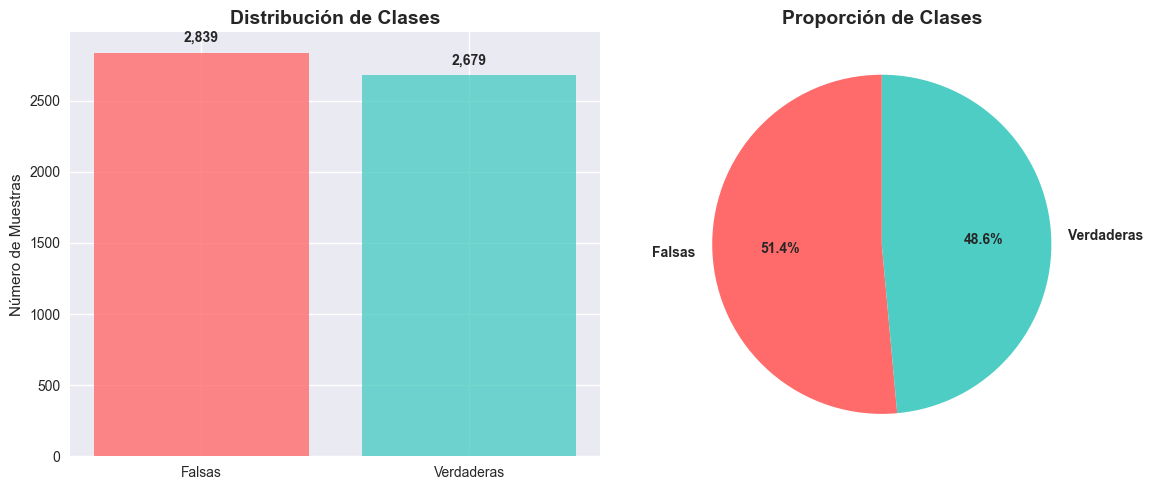

In [47]:
# === ANÁLISIS DE DISTRIBUCIÓN DE CLASES ===
def analyze_class_distribution(df: pd.DataFrame) -> None:
    """
    Analiza y visualiza la distribución de clases en el dataset
    
    Args:
        df: DataFrame con columna 'label'
    """
 
    # Conteo de clases
    class_counts = df['label'].value_counts()
    total_samples = len(df)
    
    print("DISTRIBUCIÓN DE CLASES:")
    print("-" * 40)
    for label, count in class_counts.items():
        percentage = (count / total_samples) * 100
        label_name = "Verdaderas" if label else "Falsas"
        print(f"   {label_name}: {count:,} ({percentage:.1f}%)")
    
    # Verificar balance de clases
    balance_ratio = min(class_counts) / max(class_counts)

    
    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico de barras
    class_names = ['Falsas', 'Verdaderas']
    colors = ['#ff6b6b', '#4ecdc4']
    bars = ax1.bar(class_names, class_counts.values, color=colors, alpha=0.8)
    ax1.set_title('Distribución de Clases', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Número de Muestras')
    
    # Añadir valores en las barras
    for bar, count in zip(bars, class_counts.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + total_samples*0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico de pie
    ax2.pie(class_counts.values, labels=class_names, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontweight': 'bold'})
    ax2.set_title('Proporción de Clases', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Ejecutar análisis
analyze_class_distribution(df_processed)

--------------------------------------------------
   Promedio:        182.2 palabras
   Mediana:         44.0 palabras
   Desv. Estándar:  323.5
   Mínimo:          6 palabras
   Máximo:          4647 palabras
   Total:           1,005,398 palabras

CUARTILES:
   Q1 (25%): 40.0 palabras
   Q2 (50%): 44.0 palabras
   Q3 (75%): 240.8 palabras

ESTADÍSTICAS DE CARACTERES:
--------------------------------------------------
   Promedio:        1075.7 caracteres
   Mediana:         250.0 caracteres
   Desv. Estándar:  1926.7
   Total:           5,935,865 caracteres


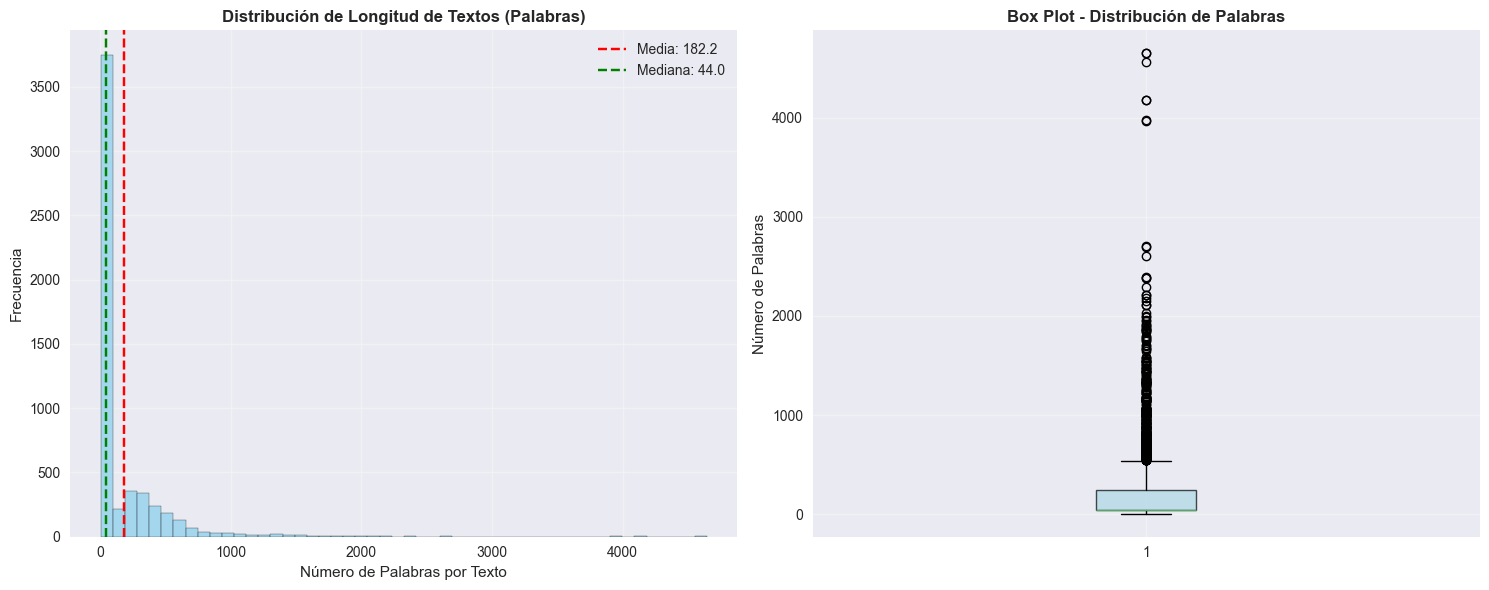

In [48]:
# === ANÁLISIS ESTADÍSTICO DEL TEXTO ===
def analyze_text_statistics(df: pd.DataFrame) -> dict:
    """
    Analiza estadísticas descriptivas del texto
    
    Args:
        df: DataFrame con columna 'text'
        
    Returns:
        dict: Diccionario con estadísticas
    """
    
    # Calcular longitud de palabras por texto
    word_lengths = df['text'].str.split().apply(len)
    char_lengths = df['text'].str.len()
    
    # Estadísticas descriptivas
    stats = {
        'word_stats': {
            'mean': word_lengths.mean(),
            'median': word_lengths.median(),
            'std': word_lengths.std(),
            'min': word_lengths.min(),
            'max': word_lengths.max(),
            'total': word_lengths.sum(),
            'q25': word_lengths.quantile(0.25),
            'q75': word_lengths.quantile(0.75)
        },
        'char_stats': {
            'mean': char_lengths.mean(),
            'median': char_lengths.median(),
            'std': char_lengths.std(),
            'min': char_lengths.min(),
            'max': char_lengths.max(),
            'total': char_lengths.sum()
        }
    }
    
    # Mostrar resultados
    print("-" * 50)
    print(f"   Promedio:        {stats['word_stats']['mean']:.1f} palabras")
    print(f"   Mediana:         {stats['word_stats']['median']:.1f} palabras")
    print(f"   Desv. Estándar:  {stats['word_stats']['std']:.1f}")
    print(f"   Mínimo:          {stats['word_stats']['min']} palabras")
    print(f"   Máximo:          {stats['word_stats']['max']} palabras")
    print(f"   Total:           {stats['word_stats']['total']:,} palabras")

    print(f"\nCUARTILES:")
    print(f"   Q1 (25%): {stats['word_stats']['q25']:.1f} palabras")
    print(f"   Q2 (50%): {stats['word_stats']['median']:.1f} palabras")
    print(f"   Q3 (75%): {stats['word_stats']['q75']:.1f} palabras")
    
    print(f"\nESTADÍSTICAS DE CARACTERES:")
    print("-" * 50)
    print(f"   Promedio:        {stats['char_stats']['mean']:.1f} caracteres")
    print(f"   Mediana:         {stats['char_stats']['median']:.1f} caracteres")
    print(f"   Desv. Estándar:  {stats['char_stats']['std']:.1f}")
    print(f"   Total:           {stats['char_stats']['total']:,} caracteres")
    
    # Visualización de distribución
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histograma de longitud de palabras
    ax1.hist(word_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(stats['word_stats']['mean'], color='red', linestyle='--', 
                label=f'Media: {stats["word_stats"]["mean"]:.1f}')
    ax1.axvline(stats['word_stats']['median'], color='green', linestyle='--', 
                label=f'Mediana: {stats["word_stats"]["median"]:.1f}')
    ax1.set_xlabel('Número de Palabras por Texto')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Longitud de Textos (Palabras)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot de longitud de palabras
    ax2.boxplot(word_lengths, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7))
    ax2.set_ylabel('Número de Palabras')
    ax2.set_title('Box Plot - Distribución de Palabras', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return stats

# Ejecutar análisis estadístico
text_statistics = analyze_text_statistics(df_processed)

In [50]:
# === EXPORTACIÓN DEL CORPUS LIMPIO ===
def save_processed_corpus(df: pd.DataFrame, output_dir: str = 'data/corpus_limpio', 
                         filename: str = 'noticias_combinadas.csv') -> bool:
    """
    Guarda el corpus procesado en la ubicación especificada
    
    Args:
        df: DataFrame procesado
        output_dir: Directorio de destino
        filename: Nombre del archivo
        
    Returns:
        bool: True si se guardó exitosamente
    """
    try:
        # Crear directorio si no existe
        output_path = BASE_DIR / output_dir
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Ruta completa del archivo
        full_path = output_path / filename
        
        # Verificar que el DataFrame no esté vacío
        if df.empty:
            print("❌ Error: DataFrame vacío, no se puede guardar")
            return False
        
        # Guardar archivo
        df.to_csv(full_path, index=False, encoding='utf-8')
        
        # Verificación del archivo guardado
        file_size = full_path.stat().st_size
        file_size_mb = file_size / (1024 * 1024)
        
        print(f"Corpus guardado exitosamente:")
        print(f"   Ubicación: {full_path}")
        print(f"   Registros: {len(df):,}")
        print(f"   Tamaño: {file_size_mb:.2f} MB ({file_size:,} bytes)")
        print(f"   Columnas: {list(df.columns)}")
        
        # Verificación de integridad
        test_df = pd.read_csv(full_path, encoding='utf-8', nrows=5)
        if len(test_df) > 0:
            print("Verificación de integridad: EXITOSA")
        
        return True
        
    except Exception as e:
        return False

def generate_processing_summary(original_df: pd.DataFrame, processed_df: pd.DataFrame) -> None:
    """
    Genera un resumen del proceso de limpieza
    """
    if original_df.empty or processed_df.empty:
        print("No se puede generar resumen: DataFrames vacíos")
        return
    
    print(f"\n{'='*60}")
    print("RESUMEN DEL PROCESAMIENTO")
    print(f"{'='*60}")
    
    # Estadísticas antes y después
    original_chars = original_df['text'].astype(str).str.len().sum()
    processed_chars = processed_df['text'].str.len().sum()
    char_reduction = ((original_chars - processed_chars) / original_chars) * 100

    print(f"Registros procesados: {len(processed_df):,}")
    print(f"Reducción de caracteres: {char_reduction:.1f}%")
    print(f"   • Antes: {original_chars:,} caracteres")
    print(f"   • Después: {processed_chars:,} caracteres")
    
    # Verificar textos vacíos o muy cortos
    empty_texts = (processed_df['text'].str.len() == 0).sum()
    short_texts = (processed_df['text'].str.split().str.len() <= 3).sum()
    
    if empty_texts > 0:
        print(f"Textos vacíos después del procesamiento: {empty_texts}")
    if short_texts > 0:
        print(f"Textos muy cortos (≤3 palabras): {short_texts}")

    print(f"Procesamiento completado exitosamente")

# Ejecutar guardado
if 'df_combined' in locals() and 'df_processed' in locals():
    success = save_processed_corpus(df_processed)
    if success:
        generate_processing_summary(df_combined, df_processed)
else:
    print("Error: No se encontraron los DataFrames necesarios para guardar")

Corpus guardado exitosamente:
   Ubicación: C:\Users\ABRAHAM\Documents\GitHub\Practica-1\data\corpus_limpio\noticias_combinadas.csv
   Registros: 5,518
   Tamaño: 5.71 MB (5,989,740 bytes)
   Columnas: ['text', 'label']
Verificación de integridad: EXITOSA

RESUMEN DEL PROCESAMIENTO
Registros procesados: 5,518
Reducción de caracteres: 3.6%
   • Antes: 6,154,493 caracteres
   • Después: 5,935,865 caracteres
Procesamiento completado exitosamente
Procesamiento completado exitosamente
